In [9]:
include("../Inversion/Plot.jl")
include("Linear.jl")
include("../Inversion/KalmanInversion.jl")

EKI_Run (generic function with 1 method)

# High Dimensional Elliptic Equation
Consider the one dimensional elliptic equation
\begin{equation*}
\begin{split}
&-\frac{d^2 \theta}{dx^2} + \theta  = f(x), \\
&\theta(0) = \theta(1) = 0.
\end{split}
\end{equation*}
Here  Dirichlet boundary conditions are applied on both ends, and $f$ defines the source:
\begin{align*}
    f(x) = \begin{cases}
               1 & 0 \leq x\leq \frac{1}{2}\\
               2 & \frac{1}{2} < x \leq 1\\
            \end{cases}. 
\end{align*}

The elliptic equation is semi-discretized by finite difference method on a uniform grid with $N_{\theta}+2$ points with $N_{\theta} = 1000$. 
The solution is $\theta_{ref} \in \mathcal{R}^{N_{\theta}}$ on these interior points.
We are interested in the inverse problem of recovering $\theta_{ref}$ from observations of $f$ on these interior points ($N_y = N_\theta$):
\begin{equation*}
    y =  G\theta + \eta,
\end{equation*}
here $\displaystyle G = (-\frac{d^2}{dx^2} + 1)$ is the discretized operator, the observation error is $\eta \sim \mathcal{N}(0, I) \in \mathcal{R}^{N_y}$. 

In [10]:
function Elliptic(N_θ::Int64)    
    h = 1/(N_θ + 1)
    
    G = Tridiagonal(fill(-1.0/h^2, N_θ-1), fill(1+2.0/h^2, N_θ), fill(-1.0/h^2, N_θ-1));
    
    x = LinRange(h, 1-h, N_θ)
    
    y = fill(1.0, N_θ)
    y[1:div(N_θ,2)] .= 2.0
    θ_ref = G\y
     
    Σ_η = Diagonal(fill(1.0^2, N_θ))
    
    return θ_ref, G, y, Σ_η, x
end

Elliptic (generic function with 1 method)

## Truncated Unscented Kalman Inversion

Since the large structure of $\theta$ lies in the Fourier sine space, we can approximate it as 
\begin{equation}
\label{eq:elliptic-reparam}
    \theta = \tau_{(1)}\sin(x\pi)+\,\cdots\, + \tau_{(N_r)} \sin(N_rx\pi) \quad \textrm{  with  } \quad N_r = 5.
\end{equation}

For UKI, the reparameterization is \cref{eq:elliptic-reparam} and the UKI is initialized with $\tau_0 \sim \\\ \mathcal{N}(0,10^2 I)$.   
For TUKI, the low-rank covariance structure is embedded in the square root of $\Lambda$:
\begin{equation*}
    Z_0 = 10\times\Big(\sin(x\pi)\quad \sin(2x\pi)\quad\cdots \quad\sin(N_rx\pi)\Big).
\end{equation*}
And the TUKI is initialied with $\theta_0 \sim \mathcal{N}(0, Z_0 Z_0^T)$. 
%
For EKI, EAKI, and ETKI, the initial ensembles are generated from the distribution $\mathcal{N}(0, Z_0 Z_0^T)$, which span the column space of $Z_0$. The ensemble size is $J= 2N_r+1$, which matches the number of $\sigma$-points of UKI and TUKI. 


The convergence of $\{m_n\}$ in terms of the relative $L_2$ norm errors is depicted in \cref{fig:Low-rank-linear}. All the Kalman inversions behave similar and converge efficiently, although the EKI suffers from random noise due to the small ensemble size. This problem illustrates how UKI uses $2N_r+1 = 11$ $\sigma$-points to solve a $N_{\theta}=1000$ dimensional inverse problem.

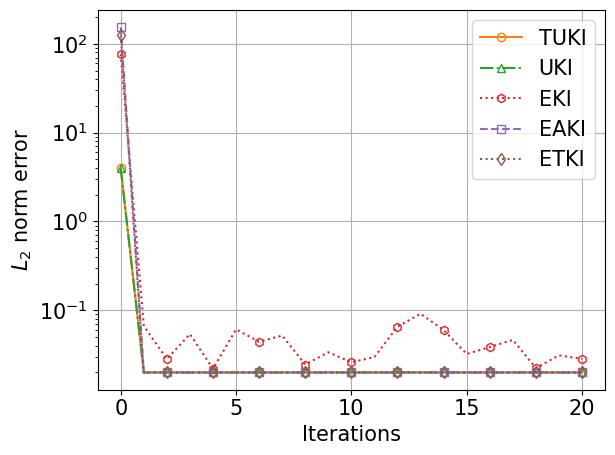

In [11]:
N_θ = 1000
θ_ref, G, y, Σ_η, x = Elliptic(N_θ)

N_y = length(y)

s_param = Setup_Param(G, N_θ, N_y)

θ0_mean = zeros(Float64, N_θ)  # mean 

α_reg = 1.0
update_freq = 0
N_iter = 20
N_r = 5
N_ens = 2N_r + 1

θθ0_cov_sqrt = ones(Float64, N_θ, N_r)
for i = 1:N_r
    θθ0_cov_sqrt[:, i] = 10.0 * sin.(i *  pi*x) 
end



# EKI 
ekiobj = EKI_Run(s_param, forward, 
"EKI",
θ0_mean, θθ0_cov_sqrt,
N_ens,
y, Σ_η,
α_reg,
update_freq,
N_iter)


# EAKI
eakiobj = EKI_Run(s_param, forward, 
"EAKI",
θ0_mean, θθ0_cov_sqrt,
N_ens,
y, Σ_η,
α_reg,
update_freq,
N_iter)

# ETKI
etkiobj = EKI_Run(s_param, forward, 
"ETKI",
θ0_mean, θθ0_cov_sqrt,
N_ens,
y, Σ_η,
α_reg,
update_freq,
N_iter)

# Truncated Unscented Kalman inversion
tukiobj = TUKI_Run(s_param, forward, 
θ0_mean, θθ0_cov_sqrt,
y, Σ_η,
α_reg,
update_freq,
N_iter)

# Unscented Kalman inversion with Reparameterization
begin  #UKI
    θ0_mean = zeros(Float64, N_r)  # mean , 
    θθ0_cov =  Array(Diagonal(fill(10.0^2, N_r)))
    
    # The basis is a N_θ × N_θ_high array 
    θ_basis = zeros(Float64, N_r, N_θ)
    for i = 1:N_r
        θ_basis[i,:] = sin.(i *  pi*x) 
    end
    ukiobj = UKI_Run(s_param, forward, 
    θ0_mean, θθ0_cov,
    y, Σ_η,
    α_reg,
    update_freq,
    N_iter;
    θ_basis = θ_basis)
end

ites = Array(LinRange(0, N_iter, N_iter+1))
errors = zeros(Float64, (5, N_iter+1))
for i = 1:N_iter+1
    errors[1, i] = norm(dropdims(mean(ekiobj.θ[i], dims=1), dims=1) .- θ_ref)
    errors[2, i] = norm(dropdims(mean(eakiobj.θ[i], dims=1), dims=1) .- θ_ref)
    errors[3, i] = norm(dropdims(mean(etkiobj.θ[i], dims=1), dims=1) .- θ_ref)
    errors[4, i] = norm(tukiobj.θ_mean[i] .- θ_ref)
    errors[5, i] = norm(θ_basis' * ukiobj.θ_mean[i]   - θ_ref)
end


markevery = max(div(N_iter, 10),1)


semilogy(ites, errors[4, :], "-o", color="C1", fillstyle="none", markevery=markevery, label= "TUKI")
semilogy(ites, errors[5, :], "-.^",  color="C2", fillstyle="none", markevery=markevery, label= "UKI")
semilogy(ites, errors[1, :], ":h",  color="C3", fillstyle="none", markevery=markevery, label= "EKI")
semilogy(ites, errors[2, :], "--s",  color="C4", fillstyle="none", markevery=markevery, label= "EAKI")
semilogy(ites, errors[3, :], ":d",  color="C5", fillstyle="none", markevery=markevery, label= "ETKI")


xlabel("Iterations")
ylabel("\$L_2\$ norm error")
#ylim((0.1,15))
grid("on")
legend()
tight_layout()


